# 0.0 IMPORT

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 0.1 Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
# Whats is low_memory?
df_raw = pd.read_csv('https://media.githubusercontent.com/media/panambY/Used_Car_Price/master/data/vehicles.csv', low_memory=False, error_bad_lines=False)

In [6]:
df_raw.sample()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
224285,7121018544,https://newjersey.craigslist.org/ctd/d/paterso...,north jersey,https://newjersey.craigslist.org,13995,2004.0,ford,f-250,NaN,NaN,gas,95956.0,clean,automatic,1FTNW21S34EC86578,4wd,NaN,pickup,black,https://images.craigslist.org/01111_flxTOejiRS...,2004 Ford F-250 F250 F 250 SD HARLEY DAVIDSON ...,NaN,nj,40.8945,-74.1524


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
df1.columns

# The columns already have a label that I want and easy to understand.

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 435849
Number of Cols: 25


## 1.3 Data Types

In [10]:
df1.dtypes
# At first, the types of the variables are corrected.

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
vin              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1117
manufacturer     20747
model             6199
condition       186806
cylinders       166384
fuel              2991
odometer         75148
title_status      1806
transmission      2146
vin             196652
drive           122011
size            295961
type            117108
paint_color     135247
image_url           24
description         27
county          435849
state                0
lat               8235
long              8235
dtype: int64

## 1.5 Fillout NA

In [12]:
# --> year

# The first variable that has an empty value and that I will deal with is the "year".
# Looking at the other variables to be able to see if I can extract some info that helps to fill in the "nan" values, I find that the "description" column has the info year inside it.
# The problem is that there are also "nan" values in the "description" column. The positive info is that there are only 27 empty values in the "description" column.
# I only looked at the observations where "description" is empty and found that, of the 27 empty values, 3 already have the "year" column filled in and the rest have almost no value filled in the other columns.
# My solution is as follows: fill the column "year" with the information contained in the column "description" not empty and drop the entire line in the 24 observations where the column "description" is empty along with several others, as we will not have enough info.
# First of all, I will drop the rows where the columns "year" and "description" are null.
df1.dropna(subset=['year', 'description'], how='all', inplace=True)
df1['year'] = df1.apply( lambda x: x['description'][:5] if math.isnan( x['year'] ) else x['year'], axis=1 )
# After fill the nan values in "year" column, there are some values that aren't year values, such as: '92 to', '03 je', 'Auto' and 'Nice'. I will transform these values by hand.
df1['year'] = df1.apply( lambda x: 1992 if x['year']=='92 to' else x['year'], axis=1 ) # We can see easily that the year is "1992"
df1['year'] = df1.apply( lambda x: 2003 if x['year']=='03 je' else x['year'], axis=1 ) # We can see easily that the year is "2003"
df1.drop(df1.loc[df1['year']=='Auto '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.
df1.drop(df1.loc[df1['year']=='Nice '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.

# --> manufacturer

# I noticed that the "description" and "model" columns have info that can help me fill in the "manufacturer" column.
# How to get the info from the "description" column will be more work at first, I'll try to do a "to" from the "model" column to fill in the "manufacturer" column.
df1['model'] = df1['model'].str.lower() # First I will apply a lower function in the "model" column.
# In the first cicle I will drop que rows that have 'model' and 'manufacturer' with nan values at the same time.
df1.drop( index=df1[df1['manufacturer'].isna() & df1['model'].isna()].index, inplace=True )
# Now I will create a dictionary with the model and its respective manufacturer.
df11 = df1[df1['manufacturer'].notna()]
df12 = df11[df11['model'].notna()]
manufacturer_dict = {}
for k, v in df12[['model', 'manufacturer']].values:
    manufacturer_dict[k] = v
df1['manufacturer'] = df1.apply( lambda x: manufacturer_dict[x['model']] if x['model'] in manufacturer_dict.keys() else x['manufacturer'], axis=1) # reduce the "nan" values to 17848, but not resolved.
# The second attempt to decrease or end "nan" values will be to take the list of manufacturers and check if they are present in the "description" column.
df1['description'] = df1['description'].str.lower()
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['description'] ) or pd.notna( x['manufacturer'] )
                                else 'ford' if 'ford' in str(x['description']).split() 
                                else 'chevrolet' if 'chevrolet' in str(x['description']).split() 
                                else 'toyota' if 'toyota' in str(x['description']).split() 
                                else 'nissan' if 'nissan' in str(x['description']).split() 
                                else 'honda' if 'honda' in str(x['description']).split()
                                else 'jeep' if 'jeep' in str(x['description']).split() 
                                else 'gmc' if 'gmc' in str(x['description']).split() 
                                else 'ram' if 'ram' in str(x['description']).split() 
                                else 'dodge' if 'dodge' in str(x['description']).split() 
                                else 'mercedes-benz' if 'mercedes-benz' in str(x['description']).split() 
                                else 'bmw' if 'bmw' in str(x['description']).split() 
                                else 'hyundau' if 'hyundai' in str(x['description']).split() 
                                else 'subaru' if 'subaru' in str(x['description']).split() 
                                else 'volkswagen' if 'volkswagen' in str(x['description']).split() 
                                else 'kia' if 'kia' in str(x['description']).split()
                                else 'chrysler' if 'chrysler' in str(x['description']).split() 
                                else 'cadillac' if 'cadillac' in str(x['description']).split() 
                                else 'lexus' if 'lexus' in str(x['description']).split() 
                                else 'buick' if 'buick' in str(x['description']).split() 
                                else 'mazda' if 'mazda' in str(x['description']).split()
                                else 'audi' if 'audi' in str(x['description']).split() 
                                else 'acura' if 'acura' in str(x['description']).split() 
                                else 'infiniti' if 'infiniti' in str(x['description']).split() 
                                else 'lincoln' if 'lincoln' in str(x['description']).split() 
                                else 'pontiac' if 'pontiac' in str(x['description']).split()
                                else 'volvo' if 'volvo' in str(x['description']).split() 
                                else 'mitsubishi' if 'mitsubishi' in str(x['description']).split() 
                                else 'mini' if 'mini' in str(x['description']).split() 
                                else 'rover' if 'rover' in str(x['description']).split() 
                                else 'mercury' if 'mercury' in str(x['description']).split() 
                                else 'saturn' if 'saturn' in str(x['description']).split() 
                                else 'fiat' if 'fiat' in str(x['description']).split() 
                                else 'jaguar' if 'jaguar' in str(x['description']).split() 
                                else 'tesla' if 'tesla' in str(x['description']).split() 
                                else 'harley-davidson' if 'harley-davidson' in str(x['description']).split()
                                else 'ferrari' if 'ferrari' in str(x['description']).split() 
                                else 'alfa-romeo' if 'alfa-romeo' in str(x['description']).split() 
                                else 'datsun' if 'datsun' in str(x['description']).split() 
                                else 'aston-martin' if 'aston-martin' in str(x['description']).split() 
                                else 'porche' if 'porche' in str(x['description']).split()
                                else 'land rover' if 'land rover' in str(x['description']).split() 
                                else 'morgan' if 'morgan' in str(x['description']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 12514, but not resolved.
# The third and last attempt I will see the values in "model" columns and find a relationtionship between "manufacturer" and "model".
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['model'] ) or pd.notna( x['manufacturer'] )
                                else 'gmc' if 'hummer' in str(x['model']).split() 
                                else 'ford' if 'freightliner' in str(x['model']).split() 
                                else 'volkswagen' if 'porsche' in str(x['model']).split() 
                                else 'isuzu' if 'isuzu' in str(x['model']).split() 
                                else 'navistar' if 'internacional ' in str(x['model']).split() 
                                else 'gmc' if 'saab' in str(x['model']).split() 
                                else 'suzuki' if 'suzuki' in str(x['model']).split() 
                                else 'paccar' if 'peterbilt' in str(x['model']).split()
                                else 'volkswagen' if 'jetta' in str(x['model']).split()
                                else 'paccar' if 'kenworth' in str(x['model']).split()
                                else 'chrysler' if 'plymouth' in str(x['model']).split()
                                else 'gmc' if 'oldsmobile' in str(x['model']).split()
                                else 'volkswagen' if 'bentley' in str(x['model']).split()
                                else 'toyota' if 'hino' in str(x['model']).split()
                                else 'gmc' if 'janesville' in str(x['model']).split()
                                else 'bmw' if 'triumph' in str(x['model']).split()
                                else 'chrysler' if 'maserati' in str(x['model']).split()
                                else 'volkswagen' if 'lamborghini' in str(x['model']).split()
                                else 'chevrolet' if 'corvette' in str(x['model']).split()
                                else 'gmc' if 'caddilac' in str(x['model']).split()
                                else 'chevrolet' if 'cheverolet' in str(x['model']).split()
                                else 'hyundau' if 'hyunday' in str(x['model']).split()
                                else 'hyundau' if 'hyundai' in str(x['model']).split()
                                else 'chevrolet' if 'chevorlet' in str(x['model']).split()
                                else 'volkswagen' if 'volkswagon' in str(x['model']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 6068, but not resolved. Thats enought for the first cicle. From the second cycle I can treat data better.
# In the rest of the values in "manufacturer" column I will input a 'unknown' value.
df1['manufacturer'].fillna( 'unknown', inplace=True )

# --> condition

# Check if you have a model with the "condition" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['condition'].notna()]
df12 = df11[df11['model'].notna()]
condition_dict = {}
for k, v in df12[['model', 'condition']].values:
    condition_dict[k] = v
df1['condition'] = df1.apply( lambda x: x['condition'] if pd.isna( x['model'] ) or pd.notna( x['condition'] ) else condition_dict[x['model']] if x['model'] in condition_dict.keys() else x['condition'], axis=1)# 28615 "nan" values left.
# as it can cause confusion between the "like new" and "new" values I will not try to fill in the "nan" values using the ifo's in the "description" variable.
# For the remaining "nan" values, enter the "unknown" value.
df1['condition'].fillna( 'unknown', inplace=True )

# --> cylinders

# Check if you have a model with the "cylinders" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['cylinders'].notna()]
df12 = df11[df11['model'].notna()]
cylinders_dict = {}
for k, v in df12[['model', 'cylinders']].values:
    cylinders_dict[k] = v
df1['cylinders'] = df1.apply( lambda x: x['cylinders'] if pd.isna( x['model'] ) or pd.notna( x['cylinders'] ) else cylinders_dict[x['model']] if x['model'] in cylinders_dict.keys() else x['cylinders'], axis=1)# 29022 "nan" values remain.
# Since the values inside the "cylinders" variable have space between them, they can cause errors in filling in the "nan" values using the "split" function.
# For the remaining "nan" values, enter the "unknown" value.
df1['cylinders'].fillna( 'unknown', inplace=True )

# --> fuel

# As it can happen that the same car model has several possibilities for "fuel" I will not use the search formula in the "model" variable.
# Check and there is a "fuel" value within the "description" variable. In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['fuel'] = df1.apply( lambda x: x['fuel'] if pd.isna( x['description'] ) or pd.notna( x['fuel'] )
                                else 'gas' if 'gas' in str(x['description']).split() 
                                else 'diesel' if 'diesel' in str(x['description']).split() 
                                else 'hybrid' if 'hybrid' in str(x['description']).split() 
                                else 'electric' if 'electric' in str(x['description']).split()
                                else x['fuel'], axis=1 ) # 2152 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['fuel'].fillna( 'unknown', inplace=True )

# --> odometer

# Trying to stipulate the value as close to reality as possible, I will fill in the "nan" values by separating this variable by the "year" column and calculating the median to try to prevent the value from being affected by possible outliers.
df1['odometer'] = df1['odometer'].fillna(df1.groupby('year')['odometer'].transform('median'))
# Since there are only 40 empty values left, I will drop all 40 lines that have "nan" values in the "odometer" column.
df1.drop(df1[df1['odometer'].isna()].index, inplace=True)

# --> title_status

# Since the values of this variable are difficult to identify effectively through queries to other columns and the total "nan" values are low, I will directly fill in the "nan" values with "unknown".
df1['title_status'].fillna( 'unknow', inplace=True )

# --> transmission

# As it can happen that the same car model has several transmission possibilities, I will not use the search formula in the variable "model".
# Check and there is the value of "transmission" inside the variable "description". In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['transmission'] = df1.apply( lambda x: x['transmission'] if pd.isna( x['description'] ) or pd.notna( x['transmission'] )
                                else 'automatic' if 'automatic' in str(x['description']).split() 
                                else 'manual' if 'manual' in str(x['description']).split()
                                else x['transmission'], axis=1 ) # 1812 "nan" values remain.
# For the remaining "nan" values, enter the "unknown" value.
df1['transmission'].fillna( 'unknow', inplace=True )

# --> drive

# Check if you have a model with the "drive" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['drive'].notna()]
df12 = df11[df11['model'].notna()]
drive_dict = {}
for k, v in df12[['model', 'drive']].values:
    drive_dict[k] = v
df1['size'] = df1.apply( lambda x: x['drive'] if pd.isna( x['model'] ) or pd.notna( x['drive'] ) else drive_dict[x['model']] if x['model'] in drive_dict.keys() else x['drive'], axis=1)# 18125 "nan" values remain.
# Check and there is a "drive" value inside the "description" variable.
df1['drive'] = df1.apply( lambda x: x['drive'] if pd.isna( x['description'] ) or pd.notna( x['drive'] )
                                else '4wd' if '4wd' in str(x['description']).split() 
                                else 'fwd' if 'fwd' in str(x['description']).split() 
                                else 'rwd' if 'rwd' in str(x['description']).split() 
                                else x['drive'], axis=1 ) # did not fill in any "nan" values.
# For the remaining "nan" values, enter the "unknown" value.
df1['drive'].fillna( 'unknow', inplace=True )

# --> size

# Check if you have a model with the "size" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['size'].notna()]
df12 = df11[df11['model'].notna()]
size_dict = {}
for k, v in df12[['model', 'size']].values:
    size_dict[k] = v
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['model'] ) or pd.notna( x['size'] ) else size_dict[x['model']] if x['model'] in size_dict.keys() else x['size'], axis=1)
# Check and there is a "size" value inside the "description" variable.
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['description'] ) or pd.notna( x['size'] )
                                else 'full-size' if 'full-size' in str(x['description']).split() 
                                else 'mid-size' if 'mid-size' in str(x['description']).split() 
                                else 'compact' if 'compact' in str(x['description']).split() 
                                else 'sub-compact' if 'sub-compact' in str(x['description']).split() 
                                else x['size'], axis=1 )
# For the remaining "nan" values, enter the "unknown" value.
df1['size'].fillna( 'unknow', inplace=True )

# --> type

# Check if you have a model with the "type" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['type'].notna()]
df12 = df11[df11['model'].notna()]
type_dict = {}
for k, v in df12[['model', 'type']].values:
    type_dict[k] = v
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['model'] ) or pd.notna( x['type'] ) else type_dict[x['model']] if x['model'] in type_dict.keys() else x['type'], axis=1)# 17472 "nan" values remain.
# Check and there is the value of "type" inside the variable "description".
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['description'] ) or pd.notna( x['type'] )
                                else 'SUV' if 'SUV' in str(x['description']).split() 
                                else 'sedan' if 'sedan' in str(x['description']).split() 
                                else 'pickup' if 'pickup' in str(x['description']).split() 
                                else 'truck' if 'truck' in str(x['description']).split() 
                                else 'coupe' if 'coupe ' in str(x['description']).split() 
                                else 'hatchback' if 'hatchback' in str(x['description']).split() 
                                else 'van' if 'van' in str(x['description']).split() 
                                else 'wagon' if 'wagon' in str(x['description']).split()
                                else 'convertible' if 'convertible' in str(x['description']).split()
                                else 'mini-van' if 'mini-van' in str(x['description']).split()
                                else 'offroad' if 'offroad' in str(x['description']).split()
                                else 'bus' if 'bus' in str(x['description']).split()
                                else x['type'], axis=1 )# 10685 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['type'].fillna( 'unknow', inplace=True )

# --> paint-color

# As it can happen that the same car model has several possibilities of "paint-color" I will not use the search formula in the variable "model".
# Check and there is the value of "paint-color" inside the variable "description".
df1['paint_color'] = df1.apply( lambda x: x['paint_color'] if pd.isna( x['description'] ) or pd.notna( x['paint_color'] )
                                else 'white' if 'white' in str(x['description']).split() 
                                else 'black' if 'black' in str(x['description']).split() 
                                else 'silver' if 'silver' in str(x['description']).split() 
                                else 'blue' if 'blue' in str(x['description']).split() 
                                else 'grey' if 'grey ' in str(x['description']).split() 
                                else 'red' if 'red' in str(x['description']).split() 
                                else 'green' if 'green' in str(x['description']).split() 
                                else 'custom' if 'custom' in str(x['description']).split()
                                else 'brown' if 'brown' in str(x['description']).split()
                                else 'yellow' if 'yellow' in str(x['description']).split()
                                else 'orange' if 'orange' in str(x['description']).split()
                                else 'purple' if 'purple' in str(x['description']).split()
                                else x['paint_color'], axis=1 ) # 89241 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['paint_color'].fillna( 'unknow', inplace=True )

# --> lat and long

# Since "lat" and "long" are directly related to "region" I will separate them by "region" and average "lat" and "long".
# Here, unlike what was done in the "odometer" variable, there is no need to use the median because the variation in this case will be very small.
df1['lat'] = df1['lat'].fillna(df1.groupby('region')['lat'].transform('mean'))
df1['long'] = df1['long'].fillna(df1.groupby('region')['long'].transform('mean')) # no missing values left.

# --> id

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['id'], axis=1, inplace=True )

# --> url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['url'], axis=1, inplace=True )

# --> region_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['region_url'], axis=1, inplace=True )

# --> model

# That column has a lot of polluted data and it would take months of work to try to correct it one by one. As I have a lot of variables with good potentials in this dataset I will choose to drop this column. 
# If the model does not perform well in the end, in the next cycles I will study the possibility of treating this column better.
# I think it is worse for the project to delete only the nan rows, but keeping the column, than to delete the entire column and not decrease the number of observations in our dataset.
df1.drop( ['model'], axis=1, inplace=True )

# --> vin

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['vin'], axis=1, inplace=True )

# --> image_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['image_url'], axis=1, inplace=True )

# --> description

# This variable is not relevant to the project, but it was extremely important in helping to fill in the "nan" values in other columns. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['description'], axis=1, inplace=True )

# --> county

# All the "county" column have null value. I will drop this column.
df1.drop( ['county'], axis=1, inplace=True )

In [13]:
df1.isna().sum()

region          0
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
lat             0
long            0
dtype: int64

## 1.6 Change Types

In [14]:
# Check if, after the treatment of the "nan" values, there was any problem of data types.
df1.dtypes

region           object
price             int64
year             object
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

In [15]:
# year
df1['year'] = df1['year'].astype( 'int64' )

In [16]:
# That's all correct!
df1.dtypes

region           object
price             int64
year              int64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [18]:
num_attributes.sample()

,price,year,odometer,lat,long
194911,3995,2010,149663.0,36.152,-115.109


In [19]:
cat_attributes.sample()

,region,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
141184,medford-ashland,toyota,unknown,6 cylinders,gas,clean,manual,4wd,4wd,truck,black,or


### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,0.0000,3.647257e+09,3.647257e+09,134933.370712,9995.0000,1.690999e+07,158.461034,26817.493962
1,year,1900.0000,2.021000e+03,1.210000e+02,2009.891472,2012.0000,9.297403e+00,-3.571246,19.998197
2,odometer,0.0000,1.000000e+07,1.000000e+07,100359.163605,95075.0000,1.057850e+05,43.668401,3584.123534
3,lat,-83.1971,7.960190e+01,1.627990e+02,38.384713,38.8840,6.002674e+00,-0.371858,7.649340
4,long,-177.0120,1.736750e+02,3.506870e+02,-94.772707,-89.2975,1.799597e+01,-0.703751,1.196016


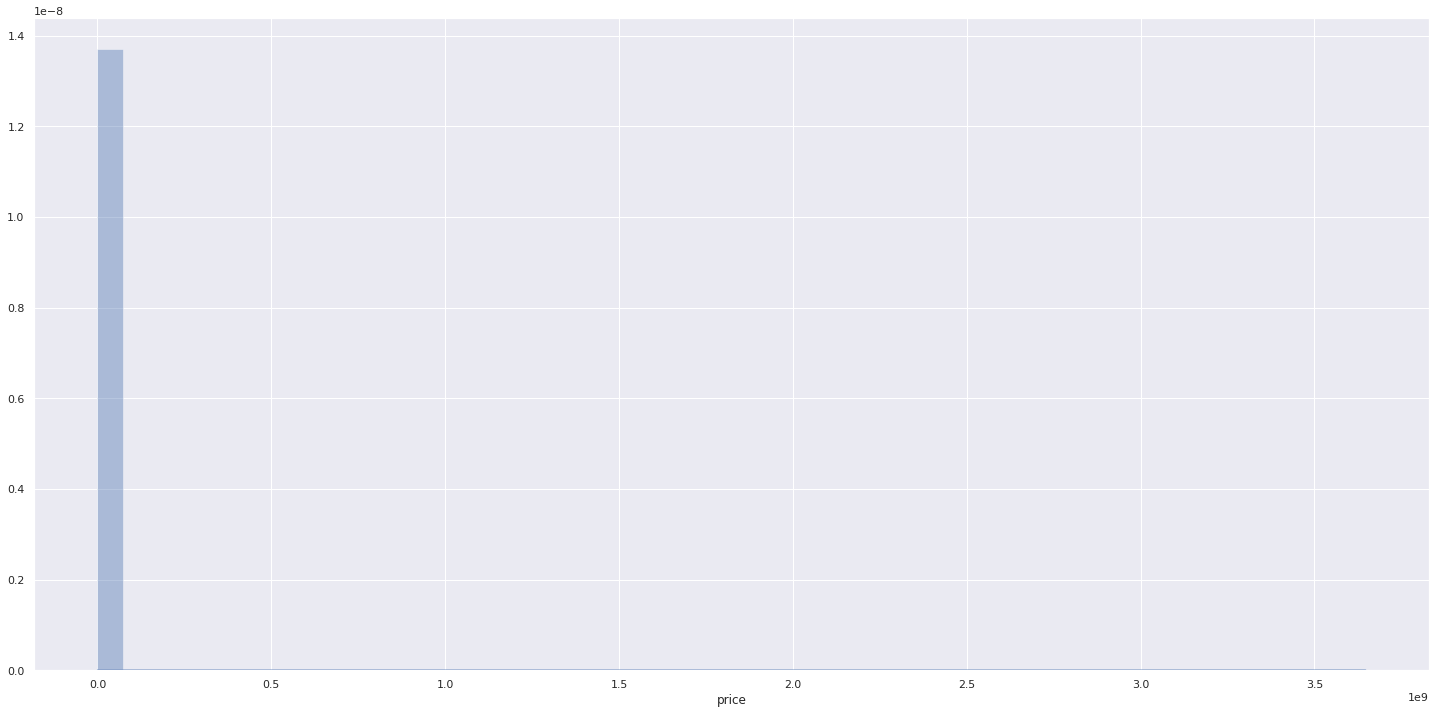

In [22]:
sns.distplot( df1['price'] )
# Observing the distribution of the target variable, we can already see the presence of outliers. This problem will be addressed later.

### 1.7.2. Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

region          403
manufacturer     47
condition         7
cylinders         9
fuel              6
title_status      7
transmission      4
drive             4
size              8
type             14
paint_color      13
state            51
dtype: int64

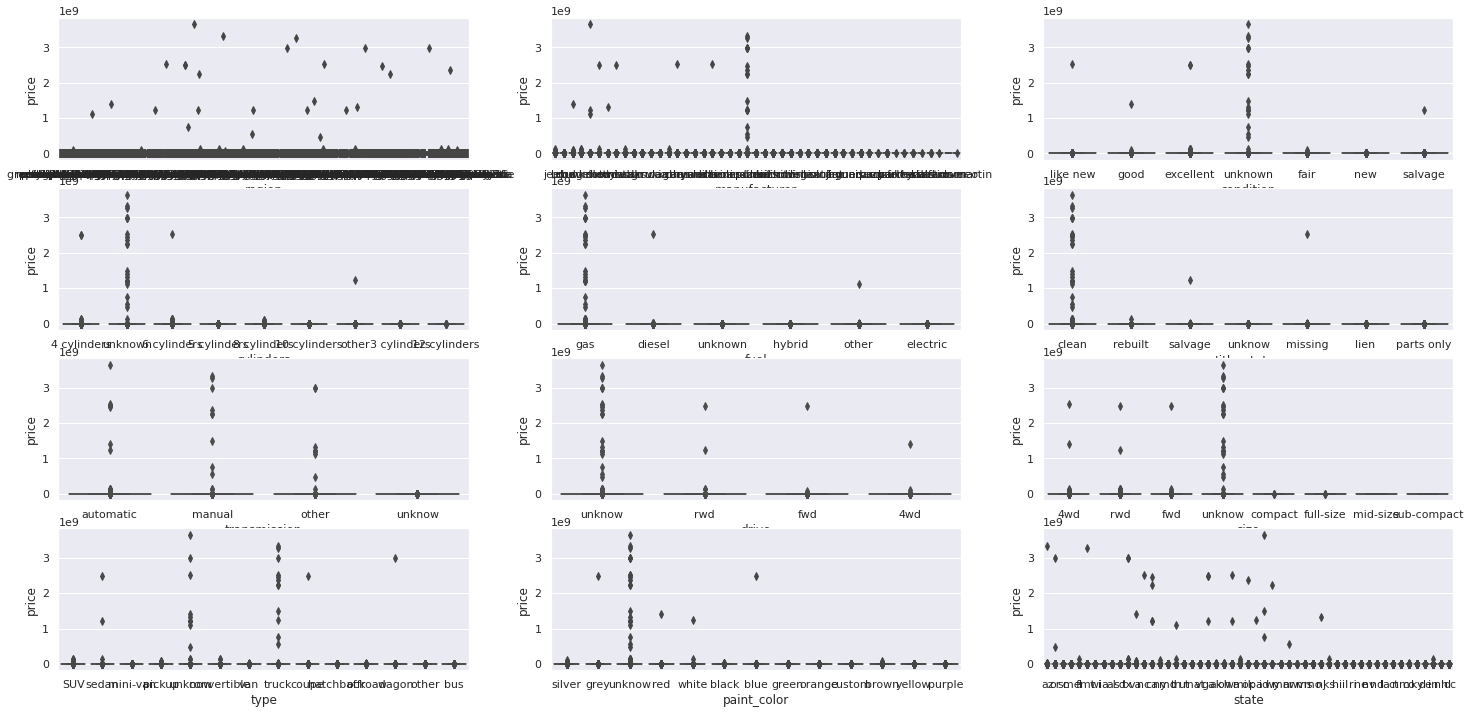

In [24]:
aux1 = df1[ df1['price'] > 0 ]


plt.subplot(4, 3, 1)
sns.boxplot( x= 'region', y='price' , data=aux1 )

plt.subplot(4, 3, 2)
sns.boxplot( x= 'manufacturer', y='price' , data=aux1 )

plt.subplot(4, 3, 3)
sns.boxplot( x= 'condition', y='price' , data=aux1 )

plt.subplot(4, 3, 4)
sns.boxplot( x= 'cylinders', y='price' , data=aux1 )

plt.subplot(4, 3, 5)
sns.boxplot( x= 'fuel', y='price' , data=aux1 )

plt.subplot(4, 3, 6)
sns.boxplot( x= 'title_status', y='price' , data=aux1 )

plt.subplot(4, 3, 7)
sns.boxplot( x= 'transmission', y='price' , data=aux1 )

plt.subplot(4, 3, 8)
sns.boxplot( x= 'drive', y='price' , data=aux1 )

plt.subplot(4, 3, 9)
sns.boxplot( x= 'size', y='price' , data=aux1 )

plt.subplot(4, 3, 10)
sns.boxplot( x= 'type', y='price' , data=aux1 )

plt.subplot(4, 3, 11)
sns.boxplot( x= 'paint_color', y='price' , data=aux1 )

plt.subplot(4, 3, 12)
sns.boxplot( x= 'state', y='price' , data=aux1 )

# The same thing observed in the numerical data can be found in the ategorical data as well: The strong presence of outliers in the dataset. 
# It is even difficult to visualize the distribution of categorical variables.

# 2.0 STEP 02 - FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

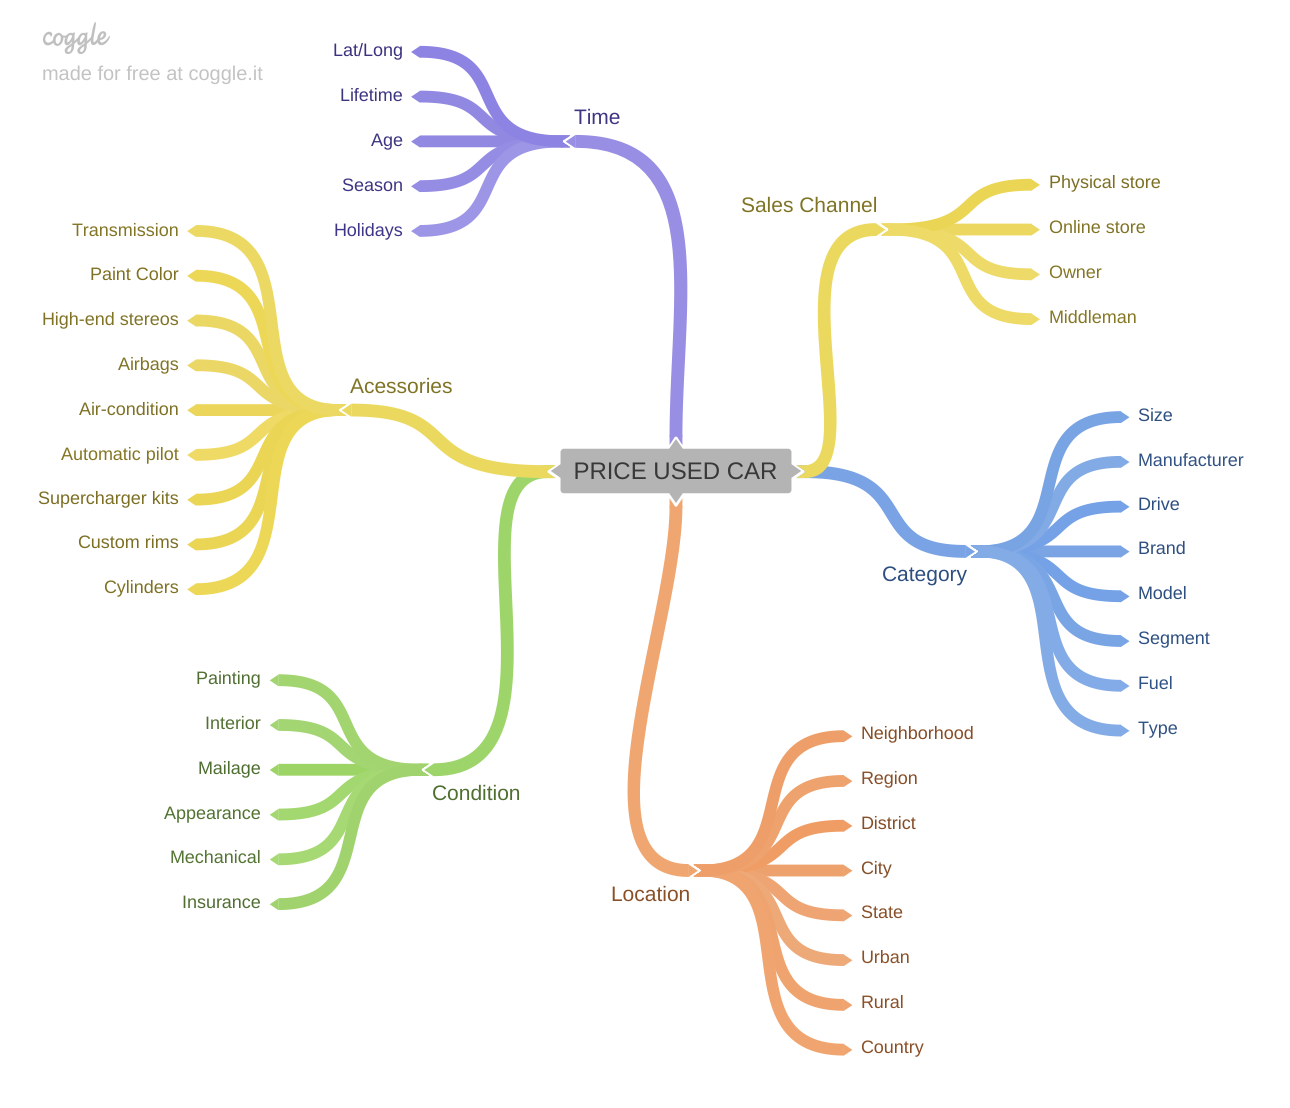

In [26]:
Image( "image/Hyphoteses_Map.png")

# To guide us in the process of exploratory data analysis I created a driagram that shows the agents and their attributes that can affect the press of used cars.

## 2.1 Creation of Hyphoteses

### 2.1.1 Condition Hyphoteses

**1.** Used cars with silver or black painting should be expensive.

**2.** Used cars which has interior with good condition should be expensive.

**3.** Used cars with high Mailage should be cheaper.

**4.** Used cars with better Appearance should be expensive.

**5.** Used cars wich has a good Mechanical should be expensive.

**6.** Used cars with any Insurance should be cheaper.

### 2.1.2 Location Hyphoteses

**1.** Used cars located in periphery neighborhood should be cheaper.

**2.** Used cars in west or northeast regions should cost more.

**3.** Used cars located in rich cities should be expensive.

**4.** Used cars in rich States should cost more.

**5.** Used cars that are in urban environments should be expensive.

**6.** Used cars that are in rural environments should cost less.

**7.** Used cars that come from another country should cost more.

### 2.1.3 Category Hyphoteses

**1.** Used cars with less size should be cheaper.

**2.** Used cars which come from big manufacturer should be cost more.

**3.** Used cars with 4wd drive should be cost more.

**4.** Used cars belongs to luxury segment should cost more.

**5.** Used cars with electric fuel should be expensive.

**6.** Used cars with SUV or truck type should cost more.

### 2.1.4 Acessories Hyphoteses

**1.** Used cars with automatic transmission should be cost more.

**2.** Used cars with silver or black paint-color should be expensive.

**3.** Used cars with high-end stereos should be expensive.

**4.** Used cars with less Airbags should be cheaper.

**5.** Used cars with air-condition should cost more.

**6.** Used cars with automatic pilot should cost more.

**7.** Used cars with supercharger kits should cost more.

**8.** Used cars with custom rims should cost more.

**9.** Used cars with more cylinders should be expensive.

### 2.1.5 Time Hyphoteses

**1.** Used cars with Lat/Long loacated in cost areas should cost more.

**2.** Used cars which has lifetime longer should be cheaper.

**3.** Used cars with less age should cost less.

**4.** Used cars selling in summer or winter season should be expensive.

**5.** Used cars selling in holidays should be expensive.

### 2.1.6 Sales Channel Hyphoteses

**1.** Used cars selling in physical store.

**2.** Used cars selling in online store should be cheaper.

**3.** Used cars selling through an owner should be cheaper.

**4.** Used cars selling through a middleman should be expensive.

## 2.2 Final List of Hyphoteses

In [27]:
# Based on some criteria, such as: information already available in the dataset and data that would be available at the beginning of the collection process. 
# I created a final list of hypotheses that, in a possible second cycle, can increase when I include another item from the previously made list.

**1.** Used cars with high Mailage should be cheaper.

**2.** Used cars with better Appearance should be expensive.

**3.** Used cars in west or northeast regions should cost more.

**4.** Used cars located in rich cities should be expensive.

**5.** Used cars in rich States should cost more.

**6.** Used cars with less size should be cheaper.

**7.** Used cars which come from big manufacturer should be cost more.

**8.** Used cars with 4wd drive should be cost more.

**9.** Used cars with electric fuel should be expensive.

**10.** Used cars with SUV or truck type should cost more.

**11.** Used cars with automatic transmission should be cost more.

**12.** Used cars with silver or black paint-color should be expensive.

**13.** Used cars with more cylinders should be expensive.

**14.** Used cars with Lat/Long loacated in cost areas should cost more.

**15.** Used cars with less age should cost less.

## 2.3 Feature Engineering

In [28]:
# First of all I will change the column name "region" to "city" name because this last one is more correct according to column content.
df2.rename( columns={"region": "city"}, inplace=True )

# region
# Create a new column named "region" which included the regions of USA, such as: northeast, midwest, south and west
# Northeast: ct, me, ma, nh, ri, vt, nj, ny, and pa
# Midwest: il, in, mi, oh, wi, ia, ks, mn, mo, ne, nd, and sd
# South: de, fl, ga, md, nc, sc, va, dc, wv, al, ky, ms, tn, ar, la, ok, and tx
# West: az, co, id, mt, nv, nm, ut, wy, ak, ca, hi, or, and wa

df2['region'] = df2['state'].replace( {"ct": "northeast", "me": "northeast", "ma": "northeast", "nh": "northeast", "ri": "northeast", "vt": "northeast", "nj": "northeast", "ny": "northeast", "pa": "northeast", "il": "midwest", 
                                       "in": "midwest", "mi": "midwest", "oh": "midwest", "wi": "midwest", "ia": "midwest", "ks": "midwest", "mn": "midwest", "mo": "midwest", "ne": "midwest", "nd": "midwest", "sd": "midwest",
                                       "de":"south", "fl":"south", "ga":"south", "md":"south", "nc":"south", "sc":"south", "va":"south", "dc":"south", "wv":"south", "al":"south", "ky":"south", "ms":"south", "tn":"south", 
                                       "ar":"south", "la":"south", "ok":"south", "tx":"south", "az":"west", "co":"west", "id":"west", "mt":"west", "nv":"west", "nm":"west", "ut":"west", "wy":"west", "ak":"west", "ca":"west",
                                       "hi":"west", "or":"west", "wa":"west"} )

# city
df2['city'] = df2['city'].str.lower()

# type
df2['type'] = df2['type'].str.lower()

In [29]:
df2.head().T

,0,1,2,3,4
city,mohave county,oregon coast,greenville / upstate,mohave county,maine
price,3495,13750,2300,9000,0
year,2012,2014,2001,2004,2021
manufacturer,jeep,bmw,dodge,chevrolet,unknown
condition,like new,good,excellent,excellent,unknown
cylinders,4 cylinders,unknown,6 cylinders,5 cylinders,unknown
fuel,gas,gas,gas,gas,other
odometer,103806,76237,199000,54000,131220
title_status,clean,clean,clean,clean,clean
transmission,automatic,automatic,automatic,automatic,other


# 3.0 STEP 03 - VARIABLE FILTERING

In [30]:
df3 = df2.copy()

In [31]:
df3.head()

,city,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,region
0,mohave county,3495,2012,jeep,like new,4 cylinders,gas,103806.0,clean,automatic,unknow,4wd,suv,silver,az,34.4554,-114.2690,west
1,oregon coast,13750,2014,bmw,good,unknown,gas,76237.0,clean,automatic,rwd,rwd,sedan,grey,or,46.1837,-123.8240,west
2,greenville / upstate,2300,2001,dodge,excellent,6 cylinders,gas,199000.0,clean,automatic,unknow,fwd,mini-van,unknow,sc,34.9352,-81.9654,south
3,mohave county,9000,2004,chevrolet,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,rwd,pickup,red,az,34.4783,-114.2710,west
4,maine,0,2021,unknown,unknown,unknown,other,131220.0,clean,other,unknow,unknow,unknow,unknow,me,44.4699,-68.8963,northeast


## 3.1 Line Filtering

In [32]:
df3[df3['odometer']<200.0].shape

(7212, 18)

In [33]:
# There are two columns which have strange values. The "price" and "odometer" variables have zero values and some very low numbers in its content.
# In this first cycle I will drop only the zero values in both columns.
df3 = df3[(df3['price']!=0) | (df3['odometer']!=0.0)]

## 3.2 Column Selection

In [34]:
# The columns that don't have relevance in this first cycle of the project, I already removed in STEP 01 when I filled tha NaN values.

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [35]:
df4 = df3.copy()

## 4.1 Univariable Analysis

### 4.1.1 Response Variable

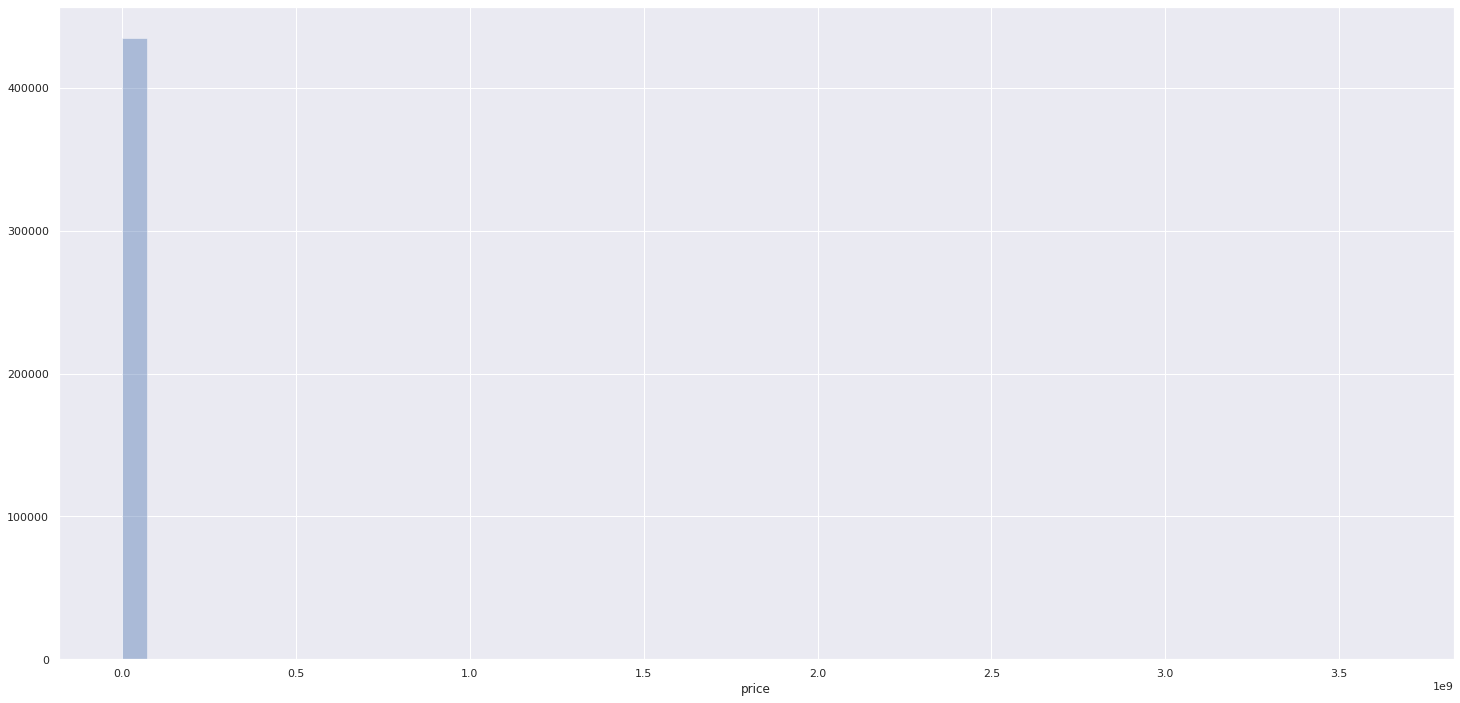

In [36]:
sns.distplot( df4['price'], kde=False )

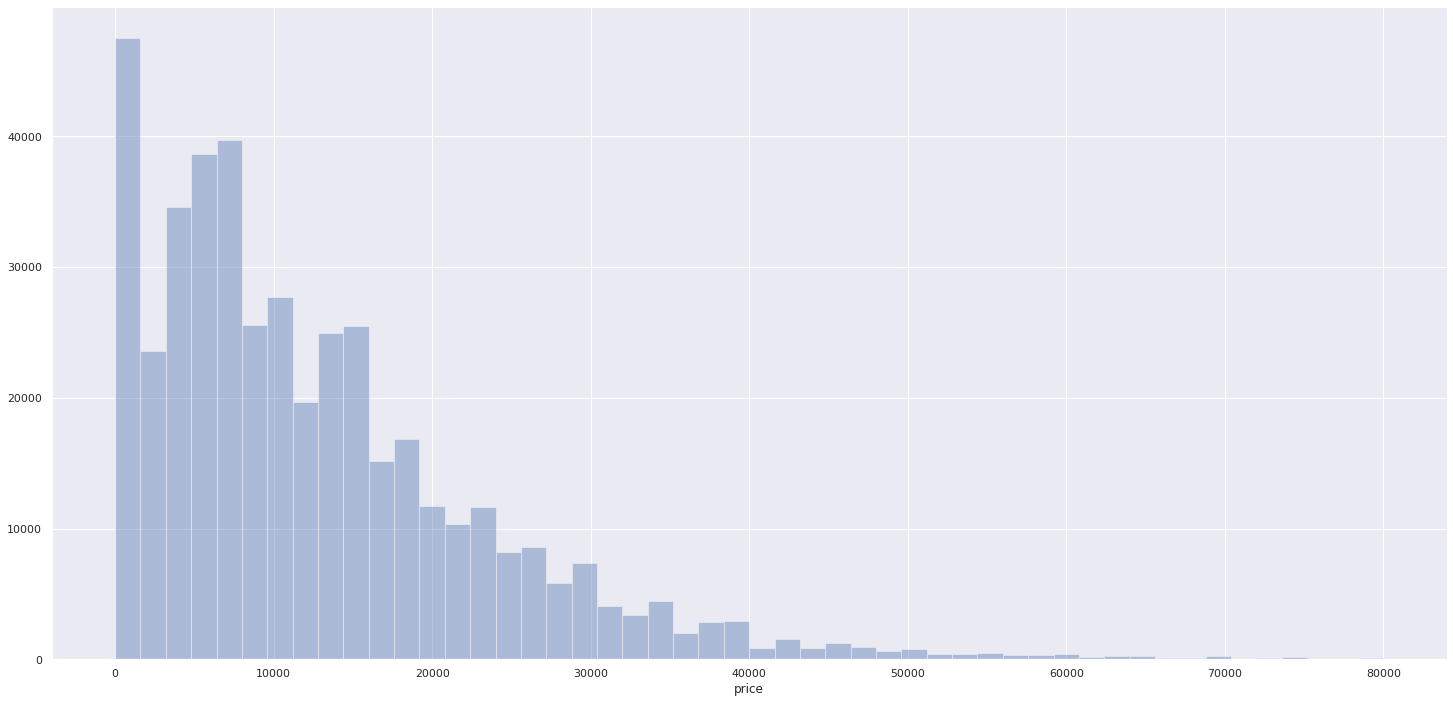

In [37]:
sns.distplot( df4[df4['price']<80000]['price'], kde=False )
# To better understand the shape of the response variable, I took some possible outliers.
# I still haven't removed the outliers because I want to use them at EDA and see if some of them can define the value of cars that are worth much above the market average and that in a way can contribute to our project.

### 4.1.2 Numerical Variable

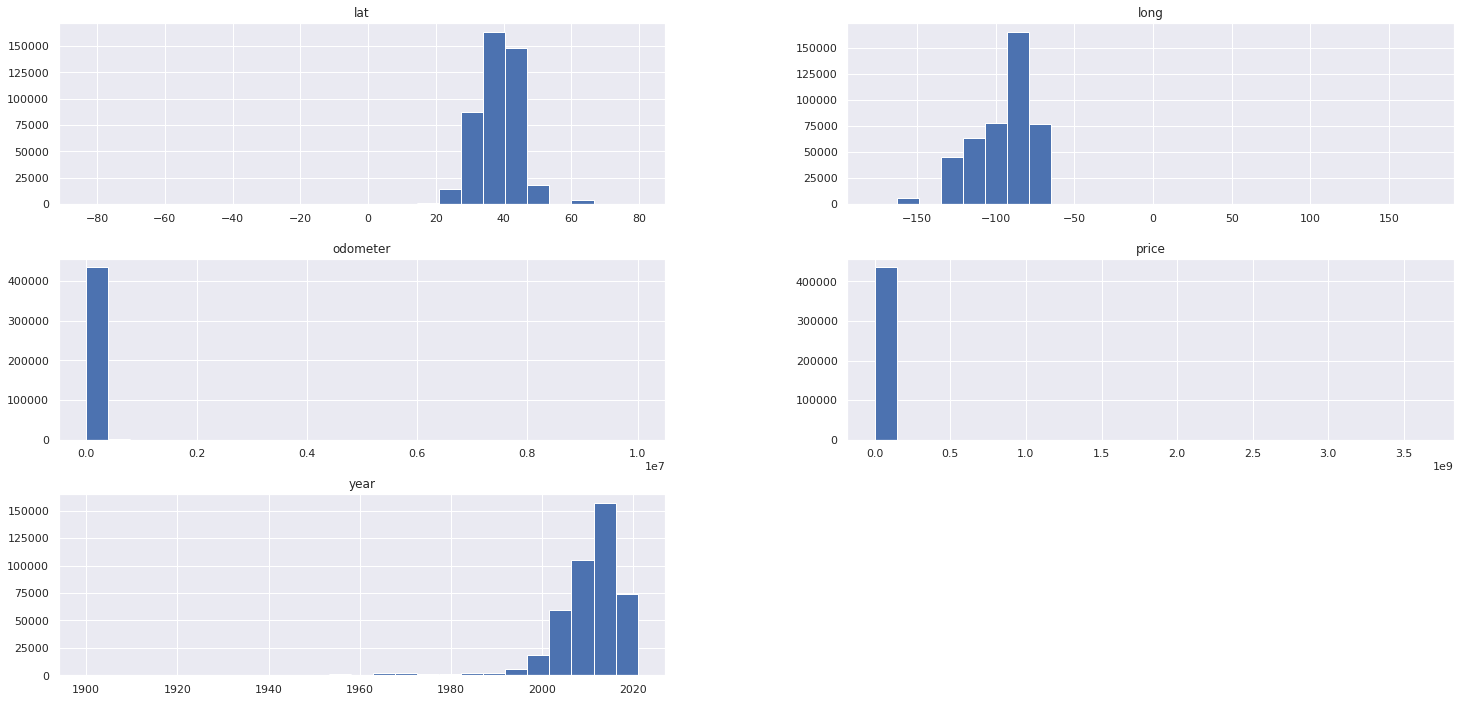

In [38]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [39]:
cat_attributes.head()

,region,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
0,mohave county,jeep,like new,4 cylinders,gas,clean,automatic,unknow,4wd,SUV,silver,az
1,oregon coast,bmw,good,unknown,gas,clean,automatic,rwd,rwd,sedan,grey,or
2,greenville / upstate,dodge,excellent,6 cylinders,gas,clean,automatic,unknow,fwd,mini-van,unknow,sc
3,mohave county,chevrolet,excellent,5 cylinders,gas,clean,automatic,rwd,rwd,pickup,red,az
4,maine,unknown,unknown,unknown,other,clean,other,unknow,unknow,unknow,unknow,me


In [40]:
df4['region'].drop_duplicates()

0          west
2         south
4     northeast
47      midwest
Name: region, dtype: object

In [41]:
df4['manufacturer'].drop_duplicates()

0                   jeep
1                    bmw
2                  dodge
3              chevrolet
4                unknown
7                   ford
8                    ram
9                  honda
10                toyota
16                nissan
19                subaru
21                   gmc
26            volkswagen
36                   kia
42                 acura
47              chrysler
53               hyundai
54              cadillac
62                 volvo
64                  mini
68         mercedes-benz
73                  audi
79                 mazda
102              pontiac
119                buick
122             infiniti
132           mitsubishi
141                rover
181               morgan
248              lincoln
276                lexus
291               saturn
370                 fiat
431               jaguar
441              hyundau
789              mercury
1002               isuzu
1050              paccar
1557              suzuki
2812              porche


In [42]:
df4['condition'].drop_duplicates()

0       like new
1           good
2      excellent
4        unknown
85          fair
86           new
318      salvage
Name: condition, dtype: object

In [43]:
df4['cylinders'].drop_duplicates()

0        4 cylinders
1            unknown
2        6 cylinders
3        5 cylinders
12       8 cylinders
59      10 cylinders
172            other
385      3 cylinders
1809    12 cylinders
Name: cylinders, dtype: object

In [44]:
df4['fuel'].drop_duplicates()

0           gas
4         other
8        diesel
104     unknown
189      hybrid
467    electric
Name: fuel, dtype: object

In [45]:
df4['title_status'].drop_duplicates()

0            clean
9          rebuilt
76         salvage
104         unknow
230        missing
273           lien
3392    parts only
Name: title_status, dtype: object

In [46]:
df4['transmission'].drop_duplicates()

0      automatic
4          other
26        manual
310       unknow
Name: transmission, dtype: object

In [47]:
df4['drive'].drop_duplicates()

0    unknow
1       rwd
8       4wd
9       fwd
Name: drive, dtype: object

In [48]:
df4['size'].drop_duplicates()

0                 4wd
1                 rwd
2                 fwd
4              unknow
153          mid-size
2092          compact
2272        full-size
301251    sub-compact
Name: size, dtype: object

In [49]:
df4['type'].drop_duplicates()

0              suv
1            sedan
2         mini-van
3           pickup
4           unknow
7      convertible
8            truck
9              van
26           coupe
50       hatchback
125        offroad
136          wagon
196          other
363            bus
Name: type, dtype: object

In [50]:
df4['paint_color'].drop_duplicates()

0      silver
1        grey
2      unknow
3         red
10      white
14      black
24       blue
29      green
69     orange
183    custom
197     brown
221    yellow
905    purple
Name: paint_color, dtype: object

In [51]:
df4['state'].drop_duplicates()

0         az
1         or
2         sc
4         me
11        fl
19        mt
47        wi
169       ia
271       al
272       sd
350       tx
401       va
856       nc
2496      ca
2576      ny
3408      md
3546      tn
5196      ut
7506      ma
9710      vt
12914     ga
16236     ak
17312     oh
19180     wa
23428     mi
27042     ok
27322     pa
27344     id
30887     wy
37068     mn
43536     ar
48865     wv
54470     ms
56143     mo
66795     nj
68831     ks
72386     hi
74201     il
76533     ri
88821     ne
90200     nv
96421     nd
101419    la
101855    ct
102122    nm
109276    co
111259    ky
148953    de
160373    in
223007    nh
251180    dc
Name: state, dtype: object

In [52]:
cat_attributes.columns

Index(['region', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

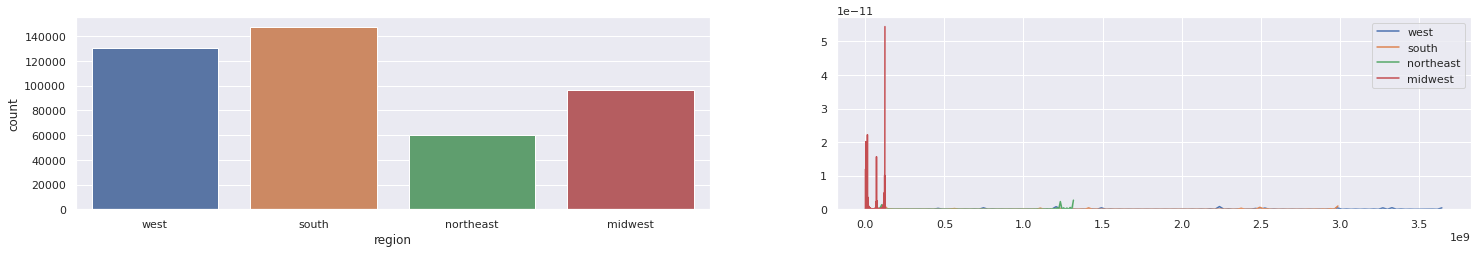

In [53]:
# region

plt.subplot( 3, 2, 1)
sns.countplot( df4['region'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['region'] == 'west']['price'], label='west', shade=True )
sns.kdeplot( df4[df4['region'] == 'south']['price'], label='south', shade=True )
sns.kdeplot( df4[df4['region'] == 'northeast']['price'], label='northeast', shade=True )
sns.kdeplot( df4[df4['region'] == 'midwest']['price'], label='midwest', shade=True )

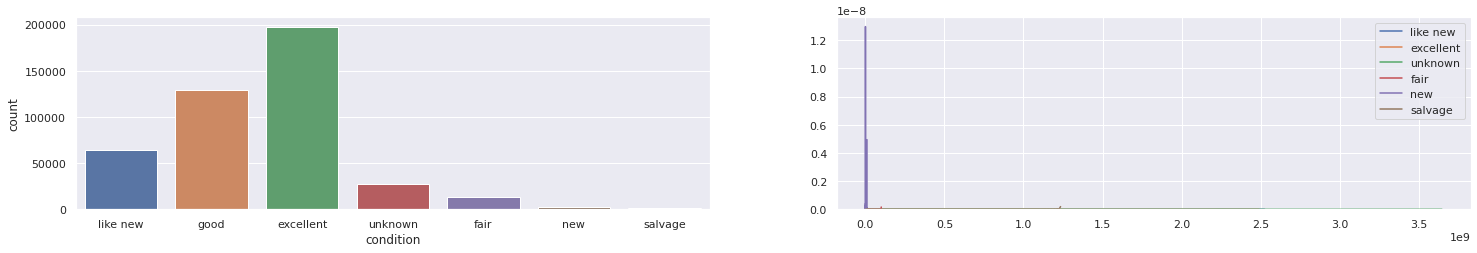

In [56]:
# condition

plt.subplot( 3, 2, 1)
sns.countplot( df4['condition'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['condition'] == 'like new']['price'], label='like new', shade=True )
sns.kdeplot( df4[df4['condition'] == 'excellent']['price'], label='excellent', shade=True )
sns.kdeplot( df4[df4['condition'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['condition'] == 'fair']['price'], label='fair', shade=True )
sns.kdeplot( df4[df4['condition'] == 'new']['price'], label='new', shade=True )
sns.kdeplot( df4[df4['condition'] == 'salvage']['price'], label='salvage', shade=True )

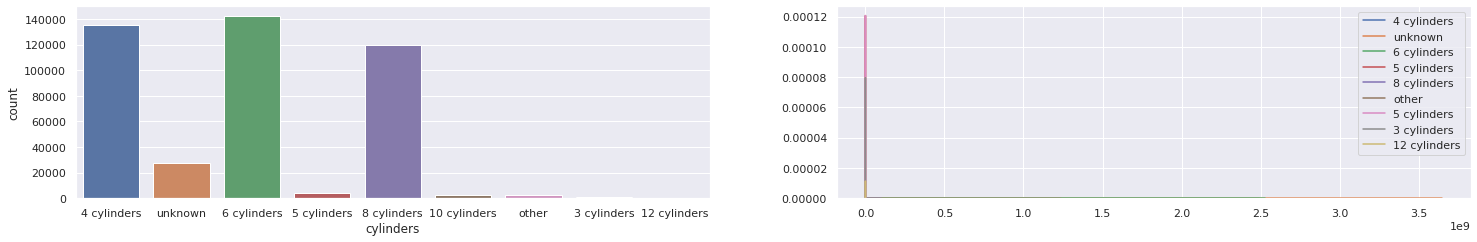

In [57]:
# cylinders

plt.subplot( 3, 2, 1)
sns.countplot( df4['cylinders'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['cylinders'] == '4 cylinders']['price'], label='4 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '6 cylinders']['price'], label='6 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '5 cylinders']['price'], label='5 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '8 cylinders']['price'], label='8 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '5 cylinders']['price'], label='5 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '3 cylinders']['price'], label='3 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '12 cylinders']['price'], label='12 cylinders', shade=True )

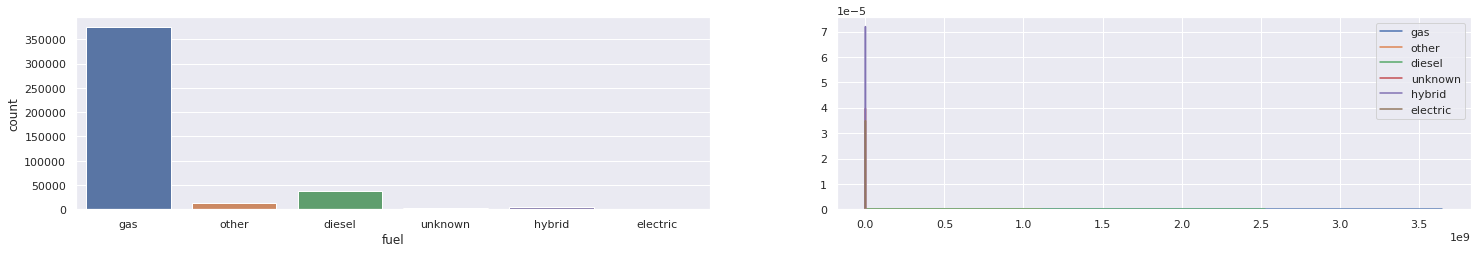

In [58]:
# fuel

plt.subplot( 3, 2, 1)
sns.countplot( df4['fuel'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['fuel'] == 'gas']['price'], label='gas', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'diesel']['price'], label='diesel', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'hybrid']['price'], label='hybrid', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'electric']['price'], label='electric', shade=True )

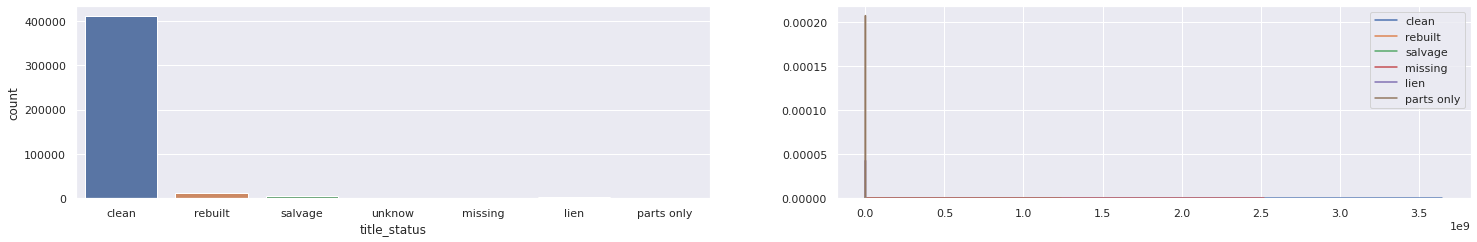

In [60]:
# title_status

plt.subplot( 3, 2, 1)
sns.countplot( df4['title_status'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['title_status'] == 'clean']['price'], label='clean', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'rebuilt']['price'], label='rebuilt', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'salvage']['price'], label='salvage', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'missing']['price'], label='missing', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'lien']['price'], label='lien', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'parts only']['price'], label='parts only', shade=True )

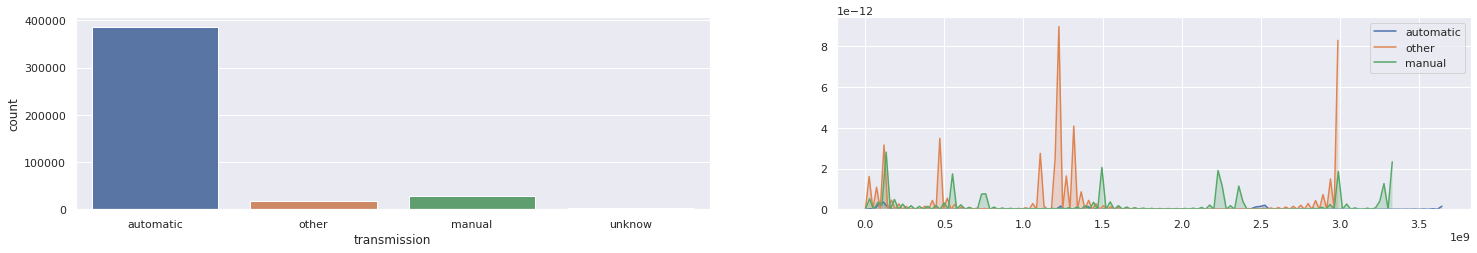

In [61]:
# transmission

plt.subplot( 3, 2, 1)
sns.countplot( df4['transmission'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['transmission'] == 'automatic']['price'], label='automatic', shade=True )
sns.kdeplot( df4[df4['transmission'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['transmission'] == 'manual']['price'], label='manual', shade=True )
sns.kdeplot( df4[df4['transmission'] == 'unknown']['price'], label='unknown', shade=True )

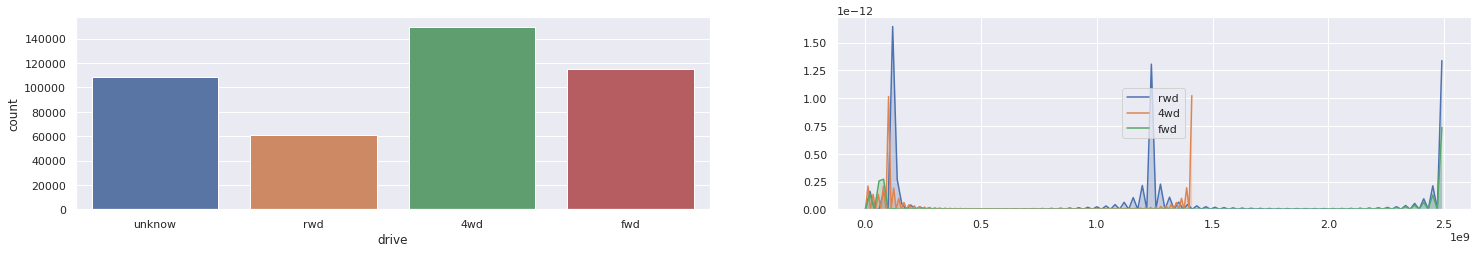

In [63]:
# drive

plt.subplot( 3, 2, 1)
sns.countplot( df4['drive'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['drive'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['drive'] == 'rwd']['price'], label='rwd', shade=True )
sns.kdeplot( df4[df4['drive'] == '4wd']['price'], label='4wd', shade=True )
sns.kdeplot( df4[df4['drive'] == 'fwd']['price'], label='fwd', shade=True )

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


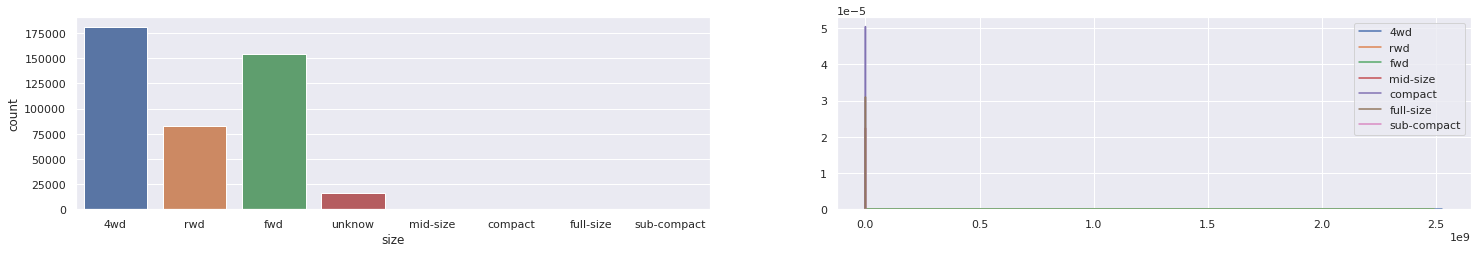

In [64]:
# size

plt.subplot( 3, 2, 1)
sns.countplot( df4['size'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['size'] == '4wd']['price'], label='4wd', shade=True )
sns.kdeplot( df4[df4['size'] == 'rwd']['price'], label='rwd', shade=True )
sns.kdeplot( df4[df4['size'] == 'fwd']['price'], label='fwd', shade=True )
sns.kdeplot( df4[df4['size'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['size'] == 'mid-size']['price'], label='mid-size', shade=True )
sns.kdeplot( df4[df4['size'] == 'compact']['price'], label='compact', shade=True )
sns.kdeplot( df4[df4['size'] == 'full-size']['price'], label='full-size', shade=True )
sns.kdeplot( df4[df4['size'] == 'sub-compact']['price'], label='sub-compact', shade=True )

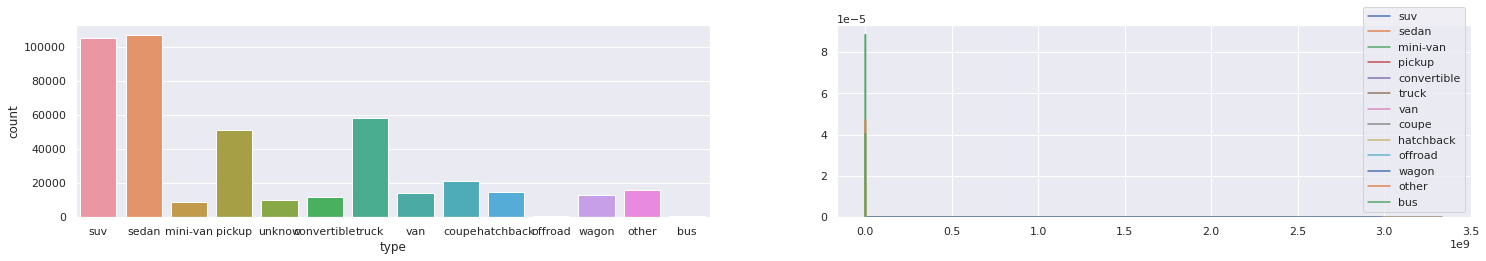

In [65]:
# type

plt.subplot( 3, 2, 1)
sns.countplot( df4['type'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['type'] == 'suv']['price'], label='suv', shade=True )
sns.kdeplot( df4[df4['type'] == 'sedan']['price'], label='sedan', shade=True )
sns.kdeplot( df4[df4['type'] == 'mini-van']['price'], label='mini-van', shade=True )
sns.kdeplot( df4[df4['type'] == 'pickup']['price'], label='pickup', shade=True )
sns.kdeplot( df4[df4['type'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['type'] == 'convertible']['price'], label='convertible', shade=True )
sns.kdeplot( df4[df4['type'] == 'truck']['price'], label='truck', shade=True )
sns.kdeplot( df4[df4['type'] == 'van']['price'], label='van', shade=True )
sns.kdeplot( df4[df4['type'] == 'coupe']['price'], label='coupe', shade=True )
sns.kdeplot( df4[df4['type'] == 'hatchback']['price'], label='hatchback', shade=True )
sns.kdeplot( df4[df4['type'] == 'offroad']['price'], label='offroad', shade=True )
sns.kdeplot( df4[df4['type'] == 'wagon']['price'], label='wagon', shade=True )
sns.kdeplot( df4[df4['type'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['type'] == 'bus']['price'], label='bus', shade=True )

In [ ]:
silver
1        grey
2      unknow
3         red
10      white
14      black
24       blue
29      green
69     orange
183    custom
197     brown
221    yellow
905    purple

# paint-color

plt.subplot( 3, 2, 1)
sns.countplot( df4['paint-color'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['paint-color'] == 'silver']['price'], label='silver', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'grey']['price'], label='grey', shade=True )
sns.kdeplot( df4[df4['paint-color-colorpe'] == 'mini-van']['price'], label='mini-van', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'pickup']['price'], label='pickup', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'convertible']['price'], label='convertible', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'truck']['price'], label='truck', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'van']['price'], label='van', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'coupe']['price'], label='coupe', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'hatchback']['price'], label='hatchback', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'offroad']['price'], label='offroad', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'wagon']['price'], label='wagon', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['paint-color'] == 'bus']['price'], label='bus', shade=True )